In [1]:
#!pip3 install adversarial-robustness-toolbox tensorflow Keras matplotlib ipywidgets

In [2]:
import os, sys
from os.path import abspath
import warnings

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from __future__ import absolute_import, division, print_function, unicode_literals
import logging
from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.trainer import AdversarialTrainerMadryPGD

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import keras.backend as k
from keras.models import load_model, Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Add, ReLU, Input
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping


# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()


np.random.seed(301)
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%matplotlib inline

/data/pramodh/miniconda3/envs/cs776/lib/python3.9/site-packages/art/estimators/certification/__init__.py:12: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")
2022-04-18 03:10:52.886783: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices()

Num GPUs Available:  1


2022-04-18 03:11:01.272465: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-18 03:11:01.275368: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-18 03:11:01.326164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-04-18 03:11:01.326399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-18 03:11:01.330348: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-18 03:11:01.330762: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [5]:


def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    print(x_clean.shape,"x_clean shape")
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]
        print(src_imgs.shape,"src images shape")

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        print(imgs_to_be_poisoned.shape,"imgs to be poisoned shape")
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0
    print(x_poison.shape,"x poison shape")
    return is_poison, x_poison, y_poison

In [6]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_dataset('cifar10')

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 50000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

y_raw_unohv = np.argmax(y_raw, axis=1)
y_raw_test_unohv = np.argmax(y_raw_test, axis = 1)

In [7]:
x_train = x_raw
x_test = x_raw_test
y_train = y_raw
y_test = y_raw_test

In [8]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [9]:
# Poison training data
percent_poison = .05
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw_unohv, percent_poison, add_modification)
x_train_pois, y_train_pois = preprocess(x_poisoned_raw, y_poisoned_raw)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test_unohv, percent_poison, add_modification)
x_test_pois, y_test_pois = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)

# Shuffle training data
n_train_pois = np.shape(y_train_pois)[0]
shuffled_indices = np.arange(n_train_pois)
np.random.shuffle(shuffled_indices)
x_train_pois = x_train_pois[shuffled_indices]
y_train_pois = y_train_pois[shuffled_indices]
poison_x_test = x_test_pois[is_poison_test]
poison_y_test = y_test_pois[is_poison_test]
clean_x_test = x_test_pois[is_poison_test == 0]
clean_y_test = y_test_pois[is_poison_test == 0]

(50000, 32, 32, 3) x_clean shape
(5069, 32, 32, 3) src images shape
(264, 32, 32, 3) imgs to be poisoned shape
(5016, 32, 32, 3) src images shape
(257, 32, 32, 3) imgs to be poisoned shape
(4887, 32, 32, 3) src images shape
(264, 32, 32, 3) imgs to be poisoned shape
(5016, 32, 32, 3) src images shape
(264, 32, 32, 3) imgs to be poisoned shape
(5012, 32, 32, 3) src images shape
(263, 32, 32, 3) imgs to be poisoned shape
(5004, 32, 32, 3) src images shape
(266, 32, 32, 3) imgs to be poisoned shape
(5054, 32, 32, 3) src images shape
(261, 32, 32, 3) imgs to be poisoned shape
(4954, 32, 32, 3) src images shape
(261, 32, 32, 3) imgs to be poisoned shape
(4954, 32, 32, 3) src images shape
(265, 32, 32, 3) imgs to be poisoned shape
(5034, 32, 32, 3) src images shape
(267, 32, 32, 3) imgs to be poisoned shape
(52632, 32, 32, 3) x poison shape
(10000, 32, 32, 3) x_clean shape
(1000, 32, 32, 3) src images shape
(53, 32, 32, 3) imgs to be poisoned shape
(1000, 32, 32, 3) src images shape
(53, 32,

In [10]:
def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x, downsample: bool, filters: int, kernel_size: int = 3):
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_resnet():

  inputs = Input(shape = (32, 32, 3))
  
  t =  Conv2D(kernel_size=(7, 7), strides=2, filters=64, padding="same", kernel_initializer="he_normal")(inputs)
  t = relu_bn(t)
  t = MaxPooling2D(pool_size=(2, 2), strides=2, padding="same")(t)

  t = residual_block(t, False, 64)
  t = residual_block(t, False, 64)
  t = residual_block(t, True, 128)
  t = residual_block(t, False, 128)
  t = residual_block(t, True, 256)
  t = residual_block(t, False, 256)
  t = residual_block(t, True, 512)
  t = residual_block(t, False, 512)
  t = GlobalAveragePooling2D()(t)
  t = Flatten()(t)
  outputs = Dense(10, activation="softmax")(t)

  model = Model(inputs, outputs)
  model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"])

  return model

In [11]:
model = create_resnet()

In [12]:
robust_classifier = KerasClassifier(model)

In [13]:
trainer = AdversarialTrainerMadryPGD(robust_classifier, eps = 8/255, eps_step = 2/255, max_iter = 7, batch_size = 128, nb_epochs = 391)

In [20]:
#5 epoch chal chuki hai
trainer.fit(x_train_pois, y_train_pois, validation_data =(poison_x_test, poison_y_test))

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: 

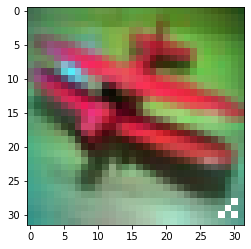

Prediction: 0

 Effectiveness of poison: 52.26%


In [21]:
poison_preds = np.argmax(robust_classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

In [22]:
poison_preds = np.argmax(robust_classifier.predict(poison_x_test), axis=1)
ct=0
for i in range(len(poison_preds)):
  jhc=(poison_preds[i]+1)%10
  if poison_y_test[i][jhc]==1:
    ct+=1
print(ct)
print(len(poison_preds))
print(100*ct/len(poison_preds)," % accuracy")

51
530
9.622641509433961  % accuracy


In [23]:
poison_preds = np.argmax(robust_classifier.predict(clean_x_test), axis=1)
ct=0
for i in range(len(poison_preds)):
  jhc=(poison_preds[i])%10
  if clean_y_test[i][jhc]==1:
    ct+=1
print(ct)
print(len(poison_preds))
print(100*ct/len(poison_preds)," % accuracy")

5905
10000
59.05  % accuracy
